# Big Data Project

Il presente progetto è stato realizzato da Luigi Gatto, Davide Lavalle e Cedric Ferdico. 
Il progetto di esame (a.a. 2020-2021) è una competizione Kaggle: un data set di frodi su carte di credito in cui sono presenti solo 492 frodi su 284808 transazioni. I dati contengono i campi "Time", "V1" ... "V28", "Amount" e "Class" che descriveremo in seguito.

È stato richiesto di effettuare tutti i passi di data cleaning/imputation e una analisi delle feature rilevanti ai fini della classificazione. 
La metrica richiesta è la Area Under the Precision-Recall Curve (AUPRC). Inoltre, è stato richiesto di effettuare il Multidimensional Scaling per realizzare una visualizzazione grafica dei dati in 2D o 3D che consenta di mettere in relazione i punti appartenenti a ciascuna classe con le feature utilizzate per la classificazione, ai fini di apprezzare l'effettiva separazione tra le classi.


## 0. Ecosistema
Per la realizzazione del progetto, si è deciso di utilizzare i seguenti strumenti:

- HDFS: per lo storage del dataset (simulando un cluster unitario di datanode); 
- Spark: per il recupero (da HDFS) e l'elaborazione del dataset;
- Pandas: per la manipolazione e l'analisi dei dati;
- Scikitlearn: per i modelli di apprendimento automatico e le metriche di valutazione dei modelli;
- Imblearn: conferisce dei tool utili alla classificazione di classi sbilanciate (utilizzata per effettuare il sovracampionamento);
- Numpy: per la gestione di matrici e array multidimensionali di grandi dimensioni e l'utilizzo di funzioni matematiche di alto livello per operare su queste strutture dati;
- Matplotlib/Seaborn: per la visualizzazione dei dati.

# 1. Descrizione del dataset

Il dataset analizzato nel progetto è un insieme di record di transazioni di carte di credito a cui è stata effettuata la PCA, per motivi di privacy. I dati sono raccolti in maniera continua: il tempo è segnato all'interno della colonna "Time" con un intero che indica l'ammontare di secondi passati tra la transazione i-esima e la prima (che, di conseguenza ha il valore di "Time" a 0). 
Il dataset analizzato presenta 284808 record di transazioni al momento dell'analisi in questo progetto.

Il dataset è fornito in formato .csv.


## 1.1. DATASET
In questa tabella andremo a riassumere il contenuto del dataset dal punto di vista delle features, descrivendone il tipo ed il contenuto. <br>
<br>

| **Feature** | **Tipo** | **Descrizione** |
|------------|------------|------------|
|  "Time" | _Int_ | Valore numerico che indica l'ammontare di secondi trascorsi tra la prima transazione e la i-esima, il valore per la prima transazione è 0. |
| "V1"..."V28" | _Float_ | Feature di dettaglio della transazione convertite con la PCA per questioni di privacy. |
| "Amount" | _Float_ | Valore numerico che indica l'ammontare della transazione. |
| "Class" | _Boolean_ | Valore 0/1 che indica se la transazione in oggetto sia frode (1) o lecita (0). |

# 2. Inizializzazione dell'ambiente
Qui andremo a descrivere brevemente la fase di inizializzazione degli strumenti utilizzati per il progetto.

## 2.1. Importazione del dataset in HDFS

Per prima cosa, dopo aver effetuato l'installazione e la configurazione di HDFS, è necessario avviare tutti i servizi Hadoop.
Per farlo è sufficiente eseguire il seguente comando da CLI: 

``` >> start-all ```

A questo punto, una volta avviati tutti i servizi, sarà possibile caricare in HDFS il dataset.
Per effettuare l'upload, sarà sufficiente eseguire un altro comando CLI:

```>> hdfs fs -put "local/path/to/file.csv" "remote/path/" ```

Dove il primo parametro sta ad indicare la directory locale in cui è conservato il file .csv mentre il secondo indicherà la directory del file system distribuito in cui il dataset sarà caricato.

## 2.2. Spark
L'inizializzazione dell'ambiente Spark consiste nell'importazione dei relativi moduli e nell'inizializzazione di una nuova SparkSession.
Il motivo per cui è stato preso in considerazione l'utilizzo di Apache Spark è stato il suo ottimo rendimento in ambiti applicativi come questo. Infatti, questo strumento, è caratterizzato da un'alta velocità di elaborazione e di analisi avanzata; inoltre, dispone di un supporto di integrazione multipla con le operazioni a basso costo di Hadoop per la gestione dell’hardware e l’immagazzinamento dei dati.

In [1]:
import findspark

location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .appName("Progetto BigData Gatto - Lavalle - Ferdico A.A. 2020/2021") \
    .getOrCreate()


21/11/01 17:09:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# 3. Lettura del dataset da HDFS con Spark

Il codice seguente permette la lettura del file da HDFS e quindi l'importazione del dataset in formato .csv all'interno del dataframe secondo lo schema appena creato.
Il dataset è conservato in una simulazione di filesystem distribuito in locale. Questa scelta è stata effettuata per permetterci di cimentarci nell'implementazione di un fs distribuito con lo strumento Hadoop.

In [2]:
dataSet = spark.read \
    .csv('hdfs://localhost:9099/user/davide/creditCardProject/creditcard.csv', header = 'True', inferSchema='True')

# 4. Dataset preprocessing
La fase di preprocessing è necessaria per preparare il dataset appena caricato prima dell'analisi vera e propria. I dati presenti possono infatti presentare errori, dati mancanti o valori non previsti. L'obiettivo del preprocessing è quindi quello di pulire tali informazioni rimuovendo o "curando" i dati che presentano rumore o qualsiasi altro tipo di inconsistenze.

## 4.1. Osservazione sul dataset


Convertiamo il DataFrame Spark in un DataFrame Pandas il quale offre delle buone API per la gestione e l'elaborazione:

In [ ]:
import pandas as pd

df = dataSet.toPandas()

Per prima cosa diamo uno sguardo a come le transazioni si evolvono nel tempo. <br>
<br>
Per farlo realizziamo un grafico che tenga conto dell'evoluzione del valore di "Amount" seguendo il trascorrere del tempo, marcando con il colore Rosso le transazioni frodi e con il colore Blu quelle lecite. <br>

Grafico: X&mdash;> Time; Y&mdash;> Amount &mdash; [Rosso frode - Blu non frode]

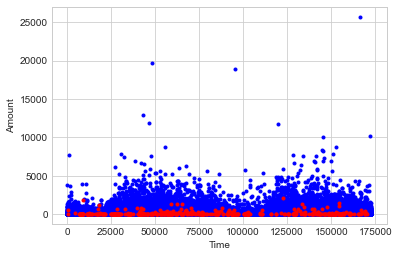

In [16]:
import numpy as np
import matplotlib.pyplot as plt

xlim = df['Time'].max() * 1.2
ylim = df['Amount'].max() * 1.2

X = np.where(df['Class']==0, df['Time'], None)
Y = np.where(df['Class']==0, df['Amount'], None)

plt.style.use('seaborn-whitegrid')
plt.xlabel("Time")
plt.ylabel("Amount")
plt.scatter(X, Y, marker = ".", color = "blue")

X = np.where(df['Class']==1, df['Time'], None)
Y = np.where(df['Class']==1, df['Amount'], None)
plt.scatter(X, Y, marker = ".", color = "red")

Da questo grafico è possibile notare come alle transazioni per cui il valore di **Class** è uguale ad 1 (le frodi) corrispondano valori di "Amount" relativamente bassi (<2500). <br>
Inoltre è possibile percepire, anche se non del tutto chiaramente, il fatto che il dataset sia sbilanciato nei confronti delle transazioni lecite. 

Per verificare lo sbilanciamento del dataset abbiamo visualizzato il numero delle transazioni lecite rispetto alle frodi:

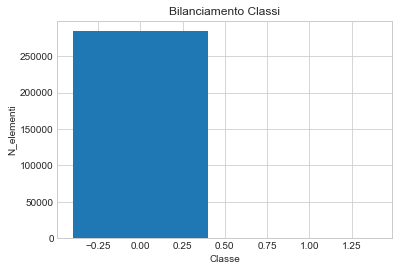

Numero transazioni lecite: 284315
Numero di frodi: 492


In [65]:
classi = []
classi.append(len(df.loc[df.Class == 0]))
classi.append(len(df.loc[df.Class == 1]))

plt.title("Bilanciamento Classi")
plt.xlabel("Classe")
plt.ylabel("N_elementi")
plt.bar([0, 1], classi)
plt.show()
print("Numero transazioni lecite: " + str(classi[0]))
print("Numero di frodi: " + str(classi[1]))

Da questa esecuzione risulta lampante lo sbilanciamento del dataset, agiremo quindi di conseguenza negli step succesivi.

## 4.2. Imputazione features mancanti e rimozione duplicati 



Banalmente, la prima operazione può essere quella di individuare le informazioni che presentano features con valori mancanti. Il trattamento di valori mancanti può avvenire fondamentalmente in due modi: cancellazione o imputazione. La scelta corretta dipende dall'obiettivo dell'analisi e dalla possibile conoscenza a priori del problema, oltre ovviamente che dalle quantità di tali valori nulli.

In [11]:
dataSet.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in dataSet.columns]).show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



Dall'esecuzione precedente è possibile notare come tutte le features presenti nel dataset non presentino dati mancanti.
Procediamo adesso con il controllo di campioni duplicati all'interno del dataset. Per farlo utilizziamo il metodo "drop_duplicates" di pandas.

In [13]:
lunghezzaIniziale = len(df)
df.drop_duplicates(subset=df.columns.values[:-1], keep='first',inplace=True)
lunghezzaFinale = len(df)
print(f"Duplicati rimossi: {lunghezzaIniziale - lunghezzaFinale}")

Duplicati rimossi: 1081


Con l'esecuzione del codice precedente sono stati eliminati i duplicati.<br>
Dato che i valori di 28 features sulle 31 totali sono il risultato di una Principal Component Analysis effettuata sul dataset originario, diventa difficile effettuare operazioni di imputazione e/o rilevamento di inconsistenze sui dati.

## 4.3. Eliminazione delle features meno rilevanti

L'eliminazione delle features meno rilevanti è necessaria per diversi motivi, tra i quali la riduzione di dimensionalità del problema (che alleggerirà il carico di lavoro successivo) e l'eliminazione di potenziali informazioni fuorvianti che sarebbero d'ostacolo all'addestramento del modello predittivo.

### 4.3.1. Matrice di correlazione

 Per l'analisi predittiva alcune delle features possono essere in qualche modo implicitamente correlate alla feature **Class** e per tale motivo utili alla sua predizione. Un possibile modo per individuare le features correlate è quello di utilizzare l'approccio statistico.
Calcolare le correlazioni tra la feature **Class** ed il resto delle features è possibile calcolando la matrice di correlazione del dataset. È chiaro quindi che vanno escluse tutte le caratteristiche aventi una correlazione con la feature presa in esame al di sotto di una certa soglia.
Per poter carcolare la matrice di correlazione, è possibile utilizzare un metodo fornito da Pandas.

Procediamo adesso con il calcolo e la visualizzazione della matrice di correlazione. Abbiamo deciso di utilizzare un valore di soglia pari a 0,05.

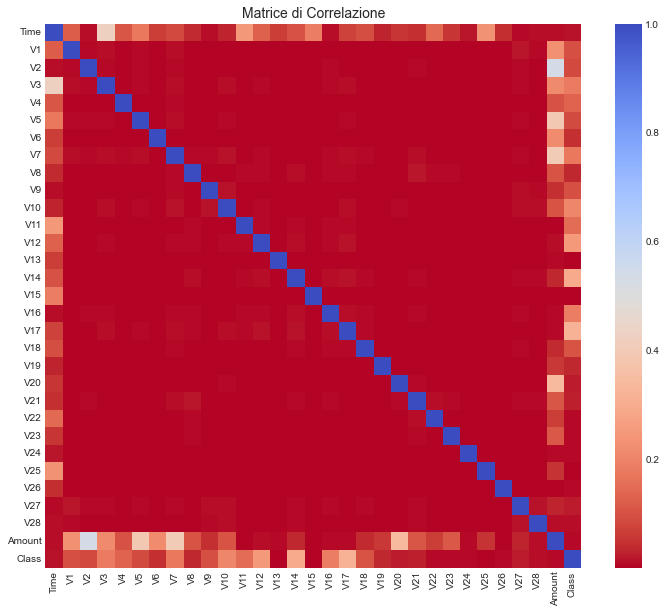

Valori minori della soglia per le feature: Time V6 V8 V13 V15 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28 Amount 

In [68]:
import seaborn as sns
soglia = 0.05

plt.figure(figsize=(12, 10))
corr = df.corr()
corr = pd.DataFrame.abs(corr)
fig = sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
fig.set_title('Matrice di Correlazione', fontsize=14)
plt.show()

count = 0
print("Valori minori della soglia per le feature: ", end="")
for i in corr["Class"]:
    if i < soglia:
        print(corr["Class"].index[count], end=" ")
    count += 1

Dalla matrice di correlazione appena ottenuta, va presa in considerazione soltanto l'ultima riga ovvero quella relativa alle correlazioni tra la feature **Class** e ognuna delle altre features.
Tanto è maggiore in valore assoluto la correlazione tra due variabili aleatorie, tanto più la conoscenza del valore di una è utile a prevedere il valore dell'altra.

Dopo aver trovato le features che, secondo la matrice di correlazione presentano un valore al disotto della soglia, analizziamo anche il fisher score per un'ulteriore conferma.

### 4.3.2. Fisher Score

Il Fisher Score risulta essere maggiore quanto più le features sono rilevanti per la discriminazione delle classi.

Per ogni feature, il Fisher Score è calcolato come: <br><br>
<font size=4><div align="center"> $F = \frac{\sum \limits _{j=1} ^{k} p_{j} (µ_{j}-µ)^{2}}{\sum \limits _{j=1} ^{k} p_{j} σ_{j}^{2}} $ </div></font>

Dove: <br>
$p_{j}$ è frazione dei dati appartenete alla classe j <br>
$µ_{j}$ è media dei dati nella classe j <br>
$σ_{j}$ è dev. standard dei dati nella classe j <br>

È stata scelta una soglia pari a 0,5. Il codice per calcolare il Fisher Score e le features che non superano una determinata soglia è il seguente:

In [69]:
def fisher(m1,s1,p1,m2,s2,p2,m3):
  m1 = float(m1)
  s1 = float(s1)
  m2 = float(m2)
  s2 = float(s2)
  m3 = float(m3)

  num = p1 * ((m1 - m3)**2) + p2*((m2 - m3)**2)
  den = p1 * (s1**2) + p2 * (s2**2)

  return (100 * num/den)

frodi = dataSet.filter(dataSet.Class.contains(1))
legittime = dataSet.filter(dataSet.Class.contains(0))

statFrodi       = frodi.describe().toPandas()
statLegittime   = legittime.describe().toPandas()
statGlobali     = dataSet.describe().toPandas()

suppFrodi       = float(statFrodi.loc[0,"Time"]) / float(statGlobali.loc[0,"Time"])
suppLegittime   = float(statLegittime.loc[0,"Time"]) / float(statGlobali.loc[0,"Time"])

print("Feature con score minori della soglia: ", end="")

for col in dataSet.columns[0:-1]:
    mediaFrodi      = float(statFrodi.loc[1,col])
    dsFrodi         = float(statFrodi.loc[2,col])
    mediaLegittime  = float(statLegittime.loc[1,col])
    dsLegittime     = float(statLegittime.loc[2,col])
    mediaGlobale    = float(statGlobali.loc[1,col])
    fisherValue = fisher(mediaFrodi, 
                          dsFrodi, 
                          suppFrodi, 
                          mediaLegittime,
                          dsLegittime,
                          suppLegittime,
                          mediaGlobale)
    
    if fisherValue < 0.5:                      
      print(col + " -", end=" ")

Feature con score minori della soglia: Time - V6 - V8 - V13 - V15 - V19 - V20 - V21 - V22 - V23 - V24 - V25 - V26 - V27 - V28 - Amount - 

### 4.3.3. Eliminazioni delle features dal dataset

Secondo la matrice di correlazione e il fisher score, le features da eliminare combaciano. Di conseguenza il prossimo blocco di codice eliminerà proprio quelle features.

In [14]:
dfFinal = df.drop(["Time", "V6", "V8", "V13", "V15", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28", "Amount"], axis=1)

## 4.4. Min max Scaling

Il min max scaling consiste nel scalare ogni feature rispetto ai valori di minimo e di massimo della stessa. Risultando, così, in un valore compreso tra 0 e 1. <br>
La scaling min max è dato da: <br>

<font size=4><div align="center"> $y_{i}^{j} = \frac{x_{i}^{j} - min(j)}{max(j)-min(j)} $ </div></font>

Questo tipo di scaling si effettua per ridurre la potenziale influenza negativa di features che assumono un ampio range di valori.  

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for col in dfFinal.columns[0:-1]:
    scaledCol = scaler.fit_transform(np.array(dfFinal[col]).reshape(-1, 1))
    dfFinal[col] = scaledCol

## 4.5. Valutazione Grafica 

Per effettuare la valutazione grafica della separazione del nostro problema tramite le features che abbiamo selezionato, abbiamo effettuato il Multidimensional Scaling ( MDS ) sul nostro dataset opportunamente modificato per poterlo rappresentare in 2D.

Il Multi Dimensional Scaling ha l'obiettivo di trovare un embedding k-dimensionale di vettori $X_{i}$ tale che minimizzi il seguente funzionale:

<font size=4><div align="center"> $O = \sum \limits _{i, j : i < j} (||X_{i} - X_{j}|| - δ_{ij})^2 $ </div></font>


Dove: <br>
$δ_{ij}$: è la distanza tra i due campioni del dataset i e j.


Eseguiremo il calcolo del MDS facendo uso prima della distanza Manhattan e poi della distanza euclidea. <br>
In rosso saranno le transazioni lecite mentre in verde le frodi.

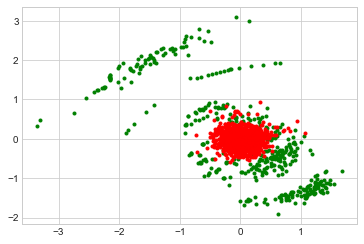

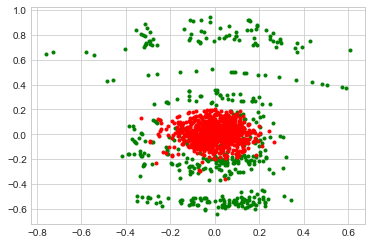

In [72]:
dfFinalClassFalse = dfFinal.loc[dfFinal.Class == 0]
dfFinalClassFalse = dfFinalClassFalse.drop(["Class"], axis = 1)

dfFinalClassTrue = dfFinal.loc[dfFinal.Class == 1]
dfFinalClassTrue = dfFinalClassTrue.drop(["Class"], axis = 1)

from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

pwsClassTrue = pairwise_distances(X = dfFinalClassTrue, metric="manhattan")
pwsClassFalse = pairwise_distances(X = dfFinalClassFalse.head(1000), metric="manhattan")

#MDS a due componenti con distanza Manhattan
embedding = MDS(n_components=2, dissimilarity="precomputed", random_state = 104)
xTrue_transformed = embedding.fit_transform(pwsClassTrue)
xFalse_transformed = embedding.fit_transform(pwsClassFalse)

plt.style.use('seaborn-whitegrid')
plt.scatter(xTrue_transformed[:, 0], xTrue_transformed[:, 1], marker = ".", color = 'green')
plt.scatter(xFalse_transformed[:, 0], xFalse_transformed[:, 1], marker = ".", color = 'red')
plt.show()

#MDS a due componenti con distanza Euclidea
embedding = MDS(n_components=2, random_state = 104)
xTrue_transformed = embedding.fit_transform(dfFinalClassTrue)
xFalse_transformed = embedding.fit_transform(dfFinalClassFalse.head(1000))

plt.style.use('seaborn-whitegrid')
plt.scatter(xTrue_transformed[:, 0], xTrue_transformed[:, 1], marker = ".", color = 'green')
plt.scatter(xFalse_transformed[:, 0], xFalse_transformed[:, 1], marker = ".", color = 'red')
plt.show()

Dai due grafici sopra, possiamo notare che le due classi siano, in generale, ben divise in quanto le transazioni lecite ( in rosso ) si trovano su una porzione limitata dello spazio.
Questo implica che il nostro problema risulta essere quindi ben discriminato dalla selezione di features effettuata. <br>
Nonostante ciò, però, ci aspettiamo comunque una presenza di falsi positivi/negativi dovuta alle zone di contatto tra i punti rossi ed i punti verdi.

## 4.6. Salvataggio del cleaned dataset.csv
E' sicuramente conveniente salvare in HDFS il dataset così ottenuto per non ripetere i passaggi di data cleaning appena descritti ad ogni nuova esecuzione. Per memorizzare il cleaned dataset nel formato csv, è possibile semplicemente utilizzare il metodo .write.csv() fornito da Spark.

In [ ]:
sparkDF = spark.createDataFrame(dfFinal) 

sparkDF.write.csv('hdfs://localhost:9099/user/davide/creditCardProject/cleaned_df.csv', header=True, mode='overwrite')

## 4.7. Importazione del cleaned dataset cleaned_df.csv
Il passaggio successivo, dunque, è quello di importare il nuovo dataset cleaned_df.csv. Per farlo è necessario costruire nuovamente lo schema del dataframe che ospiterà il dataset, utilizzare il metodo read di Spark ed infine rieffettuare la trasformazione in DataFrame Pandas.

In [3]:
cleaned_df = spark.read \
    .csv('hdfs://localhost:9099/user/davide/creditCardProject/cleaned_df.csv', header = 'True', inferSchema='True')

cleaned_df = cleaned_df.toPandas()

# 5. Modello di addestramento

## 5.1. Funzioni d'utilità
Di seguito definiremo qualche funzione che ci tornerà utile in fase di addestramento e valutazione.

### 5.1.1. La funzione **gridLearner**
La funzione **gridLearner** ci permette di effettuare una ricerca esaustiva su diversi iperparametri per un classificatore che si vuole addestrare.
* gridParams - Iperparametri del classificatore <br>
* classifier - Istanza del classificatore<br>
* X_train - Features del training set<br>
* Y_train - Classi di appartenza dei dati del training set<br>

In [4]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

def gridLearner (gridParams, classifier, X_train, Y_train):
    stratified = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1234)
    gridSearch = GridSearchCV(estimator = classifier,
                            param_grid = gridParams,
                            scoring = 'f1',
                            cv = stratified,
                            n_jobs = -1)
    gridSearch.fit(X_train, Y_train)
    return gridSearch

### 5.1.2. La funzione **matriceDiConfusione**
La funzione **matriceDiConfusione** ci permette di costruire e opzionalmente mostrare la matrice di confusione passando come parametri:
* true_labels - Classi vere <br>
* predicted_labels - Classi predette <br>
* plot - (default = True) se "True" mostra la matrice di confusione.

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def matriceDiConfusione(true_labels, predicted_labels, plot=True):
    cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1])
    cmatrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Frode","Frode"])
    
    if plot:
        cmatrix.plot()
        plt.title("Matrice di Confusione")
        plt.show()
    
    return cm

### 5.1.3. La funzione **auprc**
La funzione **auprc** ci permette di calcolare e mostrare il grafico della funzione auprc e ne restituisce il valore, passando come parametri :
* estimator - Stimatore <br>
* X_true - Feature vere <br>
* Y_true - Classi vere<br>
* Y_predictred - Classi predette <br>

In [6]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

def auprc(estimator, X_true, Y_true, Y_predicted):
    auprcValue = average_precision_score(Y_predicted, Y_true)
    display = PrecisionRecallDisplay.from_estimator(estimator, X_true, Y_true)
    _ = display.ax_.set_title("Precision-Recall Curve")
    return auprcValue

### 5.1.4. La funzione **printScores**

La funzione **printScores** ci permette di stampare i seguenti score:
* accuracy,
* precision,
* recall,
* F1,
* AUPRC insieme al relativo grafico.

Inoltre, abbiamo preferito analizzare anche uno score che indica l'accuratezza nel riconoscimento delle transazioni lecite.<br>
La funzione necessita dei seguenti parametri:

* estimator - Estimatore <br>
* confusionMatrix - Matrice di confusione <br>
* X_true - Feature vere <br>
* Y_true - Classi vere<br>
* Y_predictred - Classi predette <br>

In [7]:
from sklearn.metrics import accuracy_score

def printScores(estimator, confusionMatrix, X_true, Y_true, Y_predicted):
    veriNegativi = confusionMatrix[0][0]
    veriPositivi = confusionMatrix[1][1]
    falsiPositivi = confusionMatrix[0][1]
    falsiNegativi = confusionMatrix[1][0]   

    nonFrodiTotali = veriNegativi + falsiPositivi
    frodiTotali = veriPositivi + falsiNegativi

    percentualeDiSuccessoNonFrodi = veriNegativi / nonFrodiTotali

    precision = veriPositivi/(veriPositivi + falsiPositivi)
    recall = veriPositivi/(veriPositivi + falsiNegativi)
    print("Accuracy:                             {:.2f} %".format(accuracy_score(Y_predicted, Y_true) * 100))
    print("Precision:                            {:.2f} %".format(100 * precision))
    print("Recall-score:                         {:.2f} %".format(100 * recall))
    print("F1-score:                             {:.2f} %".format(100 * 2 * precision * recall /(precision + recall)))
    print("Accuratezza riconoscimento non frodi: {:.2f} %".format(percentualeDiSuccessoNonFrodi*100))

    auprcValue = auprc(estimator, X_true, Y_true, Y_predicted)
    baseline = frodiTotali/(frodiTotali + nonFrodiTotali)
    print("Baseline AUPRC:                       {:.5f} ".format(baseline))
    print("AUPRC model:                          {:.5f} ".format(auprcValue))

## 5.2. Suddivisione del dataset

Per effettuare l'addestramento necessitiamo di dividere il nostro dataset in due porzioni: il training set e il test set. <br>

A tale scopo, utilizziamo la funzione "train_test_split" di sklearn.

Per prima cosa, dividiamo le due partizioni e ne visualizziamo le relative dimensioni.

In [8]:
from sklearn.model_selection import train_test_split

features = cleaned_df[cleaned_df.columns[:len(cleaned_df.columns)-1]].to_numpy()
targets = cleaned_df.Class.to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=0.2, stratify=targets)

print("Dimensione Training Set  : ", len(X_train))
print("Dimensione Test Set      : ", len(X_test))

Dimensione Training Set  :  226980
Dimensione Test Set      :  56746


Prima di continuare è necessario anche analizzare il bilanciamento delle classi appartenenti alla feature **Class**. <br>
Mostriamo graficamente il bilanciamento delle due classi ( 0 lecite , 1 frodi )

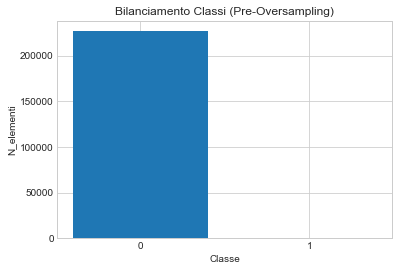

In [21]:
target_un,count = np.unique(Y_train,return_counts=True)
plt.title("Bilanciamento Classi (Pre-Oversampling)")
plt.xlabel("Classe")
plt.ylabel("N_elementi")
plt.bar([str(i) for i in target_un],count)
plt.show()

Il grafico risultante mostra una situazione di forte sbilanciamento.

## 5.3. Oversampling 
Per risolvere il problema del forte sbilanciamento del paragrafo precedente, è possibile bilanciare la distribuzione della classe " frode " attraverso l'oversampling. Questo consiste nella duplicazione dei record della classe interessata. <br>
Per effettuare l'operazione, utilizziamo il metodo SMOTE del modulo imblearn. <br>
L'oversampling sarà effettuato esclusivamente sul training set per non influenzare i risultati della predizione da parte del modello.<br>

Andiamo ad effettuare, quindi, l'oversampling e ne mostriamo il risultato:

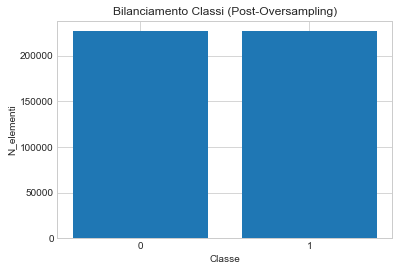

In [22]:
from imblearn.over_sampling import SMOTE

X_train_overSampled, Y_train_overSampled = SMOTE().fit_resample(X_train,Y_train)
Y_train_overSampled = Y_train_overSampled.reshape(-1,1)

target_balanced,count = np.unique(Y_train_overSampled,return_counts=True)
plt.title("Bilanciamento Classi (Post-Oversampling)")
plt.xlabel("Classe")
plt.ylabel("N_elementi")
plt.bar([str(i) for i in target_balanced],count)
plt.show()

## 5.4. Addestramento
Data la natura del problema in oggetto, i metodi di apprendimento che abbiamo utilizzato sono di natura supervisionata.
Andremo a vedere come si comportano tre modelli:

* Gausian Naive Bayes;
* Multilayer Perceptron Classifier;
* Random Forest.

Per ogni modello effettueremo un addestramento sia con il training set sovracampionato che con il training set non sovracampionato per poi osservarne i risultati tramite una matrice di confusione e i vari score.

### 5.4.1. Gaussian Naive Bayes
Il primo classificatore che abbiamo preso in considerazione è il Gaussian Naive Bayes. I Naive Bayes sono un gruppo di algoritmi di classificazione supervisionati basati sul teorema di Bayes. Un Naive Bayes è un modello di classificazione semplice, che trova ampio utilizzo quando l'input ha un'elevata dimensionalità.
Il Gaussian Naive Bayes è una variante del semplice Naive Bayes che segue la distribuzione normale Gaussiana e supporta i dati continui.

In [12]:
from sklearn.naive_bayes import GaussianNB

gaussianNB = GaussianNB()
gaussianNB.fit(X_train, Y_train.ravel())

gaussianNB_O = GaussianNB()
gaussianNB_O.fit(X_train_overSampled, Y_train_overSampled.ravel())

GNB_testPredetto = gaussianNB.predict(X_test)
GNB_O_testPredetto = gaussianNB_O.predict(X_test)

### 5.4.2. MultiLayer Perceptron Classifier 
Il secondo classificatore che abbiamo impiegato è il Multilayer Perceptron Classifier. Questo è un modello che impiega una moltitudine di percettroni organizzati in strati completamente connessi per classificare i dati.

Col codice commentato abbiamo cercato quale fosse il miglior MLP, con alcuni iperparametri fissi, al variare di altri (segnati in grassetto):

* **activation** - {tanh, relu} funzione di attivazione per il singolo percettrone.
* solver - {adam} algoritmo ottimizzato per il calcolo stocastico del gradiente.
* **hidden\_layer\_sizes** - {(150, 3), (150, 5), (200, 3), (200, 5)} ampiezza e profondità degli strati "nascosti".
* max_iter - {10000} nel caso in cui si utilizzi "adam" come solver, incide sul numero di epoche di addestramento.

Durante l'esecuzione è stato scelto il modello che avesse un migliore F1-score. In base all'esecuzione effettuata gli iperparametri migliori sono risulati:

- activation = Relu
- hidden_layer_size = (150, 5)


In [9]:
from sklearn.neural_network import MLPClassifier

#MLP = MLPClassifier(activation = "relu", solver = "adam", hidden_layer_sizes=(150,5), max_iter=10000)
#MLP.fit(X_train, Y_train.ravel())

#MLP_O = MLPClassifier(activation = "relu", solver = "adam", hidden_layer_sizes=(150,5), max_iter=10000)
#MLP_O.fit(X_train_overSampled, Y_train_overSampled.ravel())

#MLP_testPredetto = MLP.predict(X_test)
#MLP_O_testPredetto = MLP_O.predict(X_test)

x = ["tanh", "relu"] # activation
y = [(150, 3), (150, 5), (200, 3), (200, 5)] # hidden_layer_sizes

#NORMALE
best_MLP = None
best_F1 = 0
for i in x:
    for k in y:
        MLP = MLPClassifier(activation = i, solver = "adam", hidden_layer_sizes=k, max_iter=10000)
        MLP.fit(X_train, Y_train)
        testPredetto = MLP.predict(X_test)
        
        MLP_cm = matriceDiConfusione(Y_test, testPredetto, False)
        veriNegativi = MLP_cm[0][0]
        veriPositivi = MLP_cm[1][1]
        falsiPositivi = MLP_cm[0][1]
        falsiNegativi = MLP_cm[1][0]   

        precision = veriPositivi/(veriPositivi + falsiPositivi)
        recall = veriPositivi/(veriPositivi + falsiNegativi)
        f1 = 100 * 2 * precision * recall /(precision + recall)
        if f1 > best_F1:
            best_F1 = f1
            best_MLP = MLP

## OVERSAMPLED
best_MLP_O = None
best_F1 = 0
for i in x:
    for k in y:
        MLP = MLPClassifier(activation = i, solver = "adam", hidden_layer_sizes=k, max_iter=10000)
        MLP.fit(X_train_overSampled, Y_train_overSampled)
        testPredetto = MLP.predict(X_test)
        
        MLP_cm = matriceDiConfusione(Y_test, testPredetto, False)
        veriNegativi = MLP_cm[0][0]
        veriPositivi = MLP_cm[1][1]
        falsiPositivi = MLP_cm[0][1]
        falsiNegativi = MLP_cm[1][0]   

        precision = veriPositivi/(veriPositivi + falsiPositivi)
        recall = veriPositivi/(veriPositivi + falsiNegativi)
        f1 = 100 * 2 * precision * recall /(precision + recall)
        if f1 > best_F1:
            best_F1 = f1
            best_MLP_O = MLP

### 5.4.3. Random Forest

L'ultimo classificatore che abbiamo deciso di utilizzare è il random forest. Questo è un classificatore che impiega una moltitudine di alberi decisionali per classificare i dati. <br>
Nella parte commentata del blocco di codice successivo abbiamo testato il modello al variare di alcuni iperparametri:

* **Criterion**    - {Gini, Entropy} E' il criterio con la quale si misura la qualità della discriminazione delle feature in ogni albero.
* **Max_features** - {Sqrt, Log2} E' il numero delle features considerata per ogni divisione.
* **Max_depth**    - {5, 10, 15, 20, 25} Il massimo valore di profondità dell'albero.
* N_estimators - {150} Numero di alberi utilizzati nel random forest.
* N_jobs       - {-1} Il numero di job da eseguire in parallelo. -1 implica l'utilizzo di tutti i processori.

Il modello migliore è quello con i seguenti iperparametri:
* Criterion     - @TODO
* Max_features  - @TODO
* Max_depth     - @TODO

In [17]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

gridParams = {
    'criterion': ["gini", "entropy"],
    'max_features': ["sqrt", "log2"],
    'max_depth': [5, 10, 15, 20, 25]
}

rfCLF = RandomForestClassifier(n_estimators = 150, n_jobs = -1)
rf = gridLearner(gridParams, rfCLF, X_train, Y_train.ravel())

rfCLF = RandomForestClassifier(n_estimators = 150, n_jobs = -1)
rf_O = gridLearner(gridParams, rfCLF, X_train_overSampled, Y_train_overSampled.ravel())

#rf = RandomForestClassifier(n_estimators = 150, criterion = "entropy", max_features = "log2")
#rf.fit(X_train, Y_train.ravel())

#rf_O = RandomForestClassifier(n_estimators = 150, criterion = "entropy", max_features = "log2")
#rf_O.fit(X_train_overSampled, Y_train_overSampled.ravel())

rf_testPredetto = rf.predict(X_test)
rf_O_testPredetto = rf_O.predict(X_test)

# 6. Valutazione dei modelli
Ora che i modelli sono stati addestrati, è finalmente possibile iniziare la predizione della classe utilizzando il test set.
Per la valutazione dei modelli appena addestrati, vengono utilizzate le metriche fornite dalla libreria Scikit-learn, ovvero una libreria di machine learning open-source scritte in Python.

Tutte le metriche fornite dalle librerie da Scikit-learn utilizzano come parametri di input y_true e y_pred. Queste rappresentano rispettivamente le etichette reali e le etichette predette dal classificatore.

## 6.1. Matrice di confusione

La matrice di confusione è un grafico che riporta sull'asse Y le vere classi di appartenenza del dato, mentre sull'asse X le classi predette dal modello:

*  In alto a sinistra avremo le transazioni lecite classificate come tali: **_Veri Negativi_**
*  In alto a destra avremo le transazioni lecite classificate come frodi: **_Falsi Positivi_**
*  In basso a sinista avremo le transazioni frodi classificate come lecite: **_Falsi Negativi_**
*  In basso a destra avremo le transazioni frodi classificate come tali: **_Veri Positivi_**


### 6.1.1. Gaussian Naive Bayes 

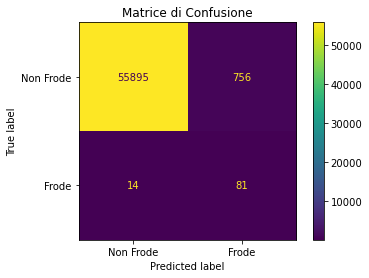

In [13]:
print("Matrice di Confusione con dataset non sovracampionato:")
GNB_cm = matriceDiConfusione(Y_test, GNB_testPredetto)

print("Matrice di Confusione con dataset sovracampionato:")
GNB_O_cm = matriceDiConfusione(Y_test, GNB_O_testPredetto)

### 6.1.2. MLP

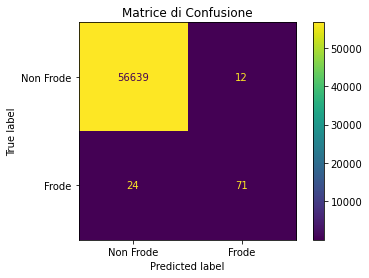

In [10]:
print("Matrice di Confusione con dataset non sovracampionato:")
MLP_cm = matriceDiConfusione(Y_test, MLP_testPredetto)

print("Matrice di Confusione con dataset sovracampionato:")
MLP_O_cm = matriceDiConfusione(Y_test, MLP_O_testPredetto)

### 6.1.3. Random Forest 

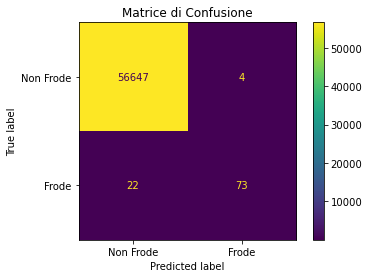

In [18]:
print("Matrice di Confusione con dataset non sovracampionato:")
rf_cm = matriceDiConfusione(Y_test, rf_testPredetto)

print("Matrice di Confusione con dataset sovracampionato:")
rf_O_cm = matriceDiConfusione(Y_test, rf_O_testPredetto)

## 6.2. Scores dei modelli

Gli scores sulla predizione sono necessari per la valutazione dei modelli.

Gli scores che abbiamo deciso di prendere in considerazione sono:

* **Accuracy**: è definita come numero di predizioni corrette diviso numero di predizioni totali.<br><br>
<font size=4> $Accuracy = \frac{ N_{correct\_predictions} } { N_{wrong\_predictions} } $ </font>
<br><br>

* **Precision**: si calcola come il rapporto tra veri positivi diviso la somma tra veri positivi e falsi positivi. <br><br>
<font size=4> $Precision = \frac{ N_{true\_positives} }{ N_{false\_positives} + N_{true\_positives} } $ </font>
<br><br>

* **Recall-score**: rappresenta la capacità del modello di classificare correttamente i positivi. Si calcola come il rapporto tra veri positivi diviso le frodi totali. <br><br>
<font size=4> $Recall = \frac{ N_{true\_positives}}{ N_{total\_fraud} } $ </font>
<br><br>

* **F1-score**: si ottiene come il doppio del rapporto tra N e D, dove N è uguale al prodotto tra precision e recall, D è la somma tra precision e recall. <br><br>
<font size=4> $F1 = 2 * \frac{ Precision * Recall }{ Precision + Recall } $ </font> 
<br><br>

* **Accuratezza riconoscimento non frodi**: l'abbiamo calcolata come il rapporto tra veri negativi e il numero di transazioni lecite totali: <br><br>
<font size=4> $AR_{lecit} = \frac{ N_{true\_negative}}{N_{total\_lecit}} $ </font>
<br><br>

* **AUPRC**: il parametro Area Under Precision Recall Curve è una metrica utile per misurare le performance di un modello applicato ad un problema non bilanciato, dove ha molta importanza il riconoscimento degli esempi positivi. L'interpretazione di questo parametro dipende fortemente dal livello di bilanciamento del problema per cui, per interpretarlo, è necessario calcolare la "baseline" del problema. Un valore generico di 0.50 per l'AUPRC potrebbe essere ottimo per un problema con una baseline di 0.05, ma pessimo per un problema con una baseline di 0.80. Il valore di "baseline" è calcolato come la porzione di elementi con classe positiva nel dataset: <br><br>
<font size=4> $Baseline = \frac{ N_{positives}}{N_{totals}} $ </font>


### 6.2.1. Gaussian Naive Bayes

Accuracy:                             98.64 %
Precision:                            9.68 %
Recall-score:                         85.26 %
F1-score:                             17.38 %
Accuratezza riconoscimento non frodi: 98.67 %
Baseline AUPRC:                       0.00167 
AUPRC model:                          0.09584 


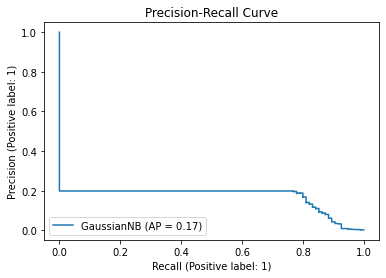

In [14]:
print("Valutazione con dataset non sovracampionato:")
printScores(gaussianNB, GNB_cm, X_test, Y_test, GNB_testPredetto)

print("Valutazione con dataset sovracampionato:")
printScores(gaussianNB_O, GNB_O_cm, X_test, Y_test, GNB_O_testPredetto)

### 6.2.2. MLP

Accuracy:                             99.94 %
Precision:                            85.54 %
Recall-score:                         74.74 %
F1-score:                             79.78 %
Accuratezza riconoscimento non frodi: 99.98 %
Baseline AUPRC:                       0.00167 
AUPRC model:                          0.63953 


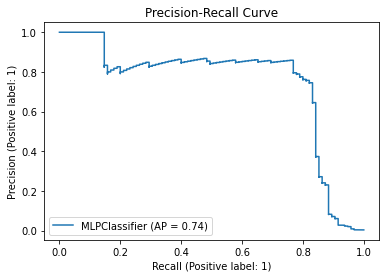

In [11]:
print("Valutazione con dataset non sovracampionato:")
printScores(MLP, MLP_cm, X_test, Y_test, MLP_testPredetto)

print("Valutazione con dataset sovracampionato:")
printScores(MLP_O, MLP_O_cm, X_test, Y_test, MLP_O_testPredetto)

### 6.2.3. Random Forest

Accuracy:                             99.95 %
Precision:                            94.81 %
Recall-score:                         76.84 %
F1-score:                             84.88 %
Accuratezza riconoscimento non frodi: 99.99 %
Baseline AUPRC:                       0.00167 
AUPRC model:                          0.72857 


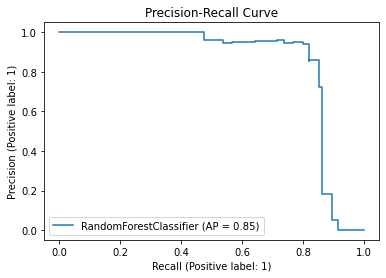

In [19]:
print("Valutazione con dataset non sovracampionato:")
printScores(rf, rf_cm, X_test, Y_test, rf_testPredetto)

print("Valutazione con dataset sovracampionato:")
printScores(rf_O, rf_O_cm, X_test, Y_test, rf_O_testPredetto)

# 7. CONCLUSIONI

Tra i diversi classificatori addestrati, il Random Forest risulta essere il modello più adatto, in termini di performance, per la classificazione del nostro problema. 
In particolare con questi iperparametri: entropy, log2, ... non mi sembra lo diciamo da nessuna parte 

Inoltre, nonostante ci aspettassimo migliori risultati dai modelli addestrati con il training set su cui è stato effettuato sovracampionamento, le performance migliori sono arrivate dai modelli addestrati con training set su cui questa operazione non è stata effettuata.

Oltretutto bisogna considerare che, a causa della PCA effettuata sul data set, durante la fase di cleaning dei dati non è stato possibile effettuare alcun tipo di imputazione, aggregazione o ragionamento sul significato delle singole feature.

Un ulteriore fattore influente è il fortissimo sbilanciamento che pensavamo non permettesse ai classificatori di discriminare in maniera ottimale le classi positive. Ciò che però abbiamo constatato è stata l'inefficacia del sovracampionamento che credevamo potesse essere utile per limitare il problema sopracitato.

Il team è soddisfatto dal risultato ottenuto e ci teniamo a precisare che abbiamo percorso molteplici strade prima di arrivare a questo risultato effettuando diversi addestramenti e modificando tutti i vari possibili iperparametri.
Questa attività ci ha permesso di mettere in pratica le nozioni studiate durante il corso permettendoci anche di capire, con un'applicazione reale, la vera efficacia dei modelli di apprendimento per la risoluzione di problemi di classificazione. 